In [1]:

import pandas as pd
import numpy as np

# Data Viz library
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df_FW = pd.read_csv(r'C:\Users\JayNB\OneDrive\เดสก์ท็อป\NIDA\ML_QUIZ\log2.csv')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X = df_FW[["Destination Port","NAT Source Port","NAT Destination Port", "Bytes","pkts_sent","Elapsed Time (sec)"]]

df_FW['Action'] = df_FW.Action.replace(['allow', 'drop', 'deny', 'reset-both'],['1','2','3','4'])
Y = df_FW[['Action']]

<Axes: xlabel='NAT Source Port', ylabel='NAT Destination Port'>

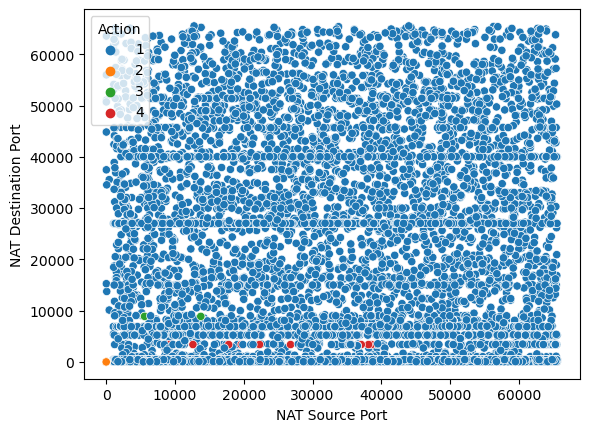

In [56]:
sns.scatterplot(data = df_FW, x = "NAT Source Port", y = "NAT Destination Port", hue = "Action")

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=37)

In [58]:
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


# Encode y to numeric
y_encoded = OrdinalEncoder().fit_transform(Y)
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')
   
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=37, stratify=y_encoded)


In [63]:
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state = 37).fit_resample(X_train, y_train)



In [64]:
# แสดงจำนวนก่อนสุ่ม OverSampling

print("Before OverSampling, counts 'allow': {}".format(sum(y_train == 0)))
print("Before OverSampling, counts 'deny': {} ".format(sum(y_train == 1)))
print("Before OverSampling, counts 'drop': {} ".format(sum(y_train == 2)))
print("Before OverSampling, counts 'reset-both': {} \n".format(sum(y_train == 3)))

Before OverSampling, counts 'allow': [28230]
Before OverSampling, counts 'deny': [9638] 
Before OverSampling, counts 'drop': [11240] 
Before OverSampling, counts 'reset-both': [41] 



In [61]:
# แสดงจำนวนหลังสุ่ม OverSampling

print("After OverSampling, counts 'allow': {}".format(sum(y_resampled == 0)))
print("After OverSampling, counts 'deny': {} ".format(sum(y_resampled == 1)))
print("After OverSampling, counts 'drop': {} ".format(sum(y_resampled == 2)))
print("After OverSampling, counts 'reset-both': {} \n".format(sum(y_resampled == 3)))

After OverSampling, counts 'allow': 28230
After OverSampling, counts 'deny': 28230 
After OverSampling, counts 'drop': 28230 
After OverSampling, counts 'reset-both': 28230 



In [37]:
##https://www.datacamp.com/tutorial/xgboost-in-python
# Train a model using the scikit-learn API
#xgb_classifier = xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3)
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,f1_score
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_resampled, y_resampled)


# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

# xgb_acc_train = xgb_classifier.score(X_resampled, y_resampled)
# xgb_acc_test = xgb_classifier.score(X_test, y_test)

print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9410
         1.0       1.00      1.00      1.00      3213
         2.0       1.00      0.99      0.99      3747
         3.0       0.21      0.92      0.34        13

    accuracy                           1.00     16383
   macro avg       0.80      0.98      0.83     16383
weighted avg       1.00      1.00      1.00     16383



In [65]:
scores = cross_val_score(xgb_classifier,X_resampled, y_resampled ,cv=5, scoring='f1_macro')
scores

array([0.99596728, 0.99561318, 0.9961009 , 0.99490165, 0.99468077])

In [168]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

1.00 accuracy with a standard deviation of 0.00


In [31]:
print(confusion_matrix(y_test, y_pred))

[[9409    0    1    0]
 [   0 3213    0    0]
 [   0    9 3695   43]
 [   0    0    2   11]]


In [34]:
print(accuracy_score(y_test, y_pred))

0.9966428615027773


In [35]:
print(f1_score(y_test, y_pred,average = 'weighted'))

0.9974726197825883


In [54]:
# Create StratifiedKFold object
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

# Train XGBoost model with stratified sampling
for train_index, test_index in skf.split(X, y_encoded):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [65532, 58979]

In [48]:
print(accuracy_score(y_test, y_pred))

0.9970701336751511
